# Volatilidad Implicita

In [1]:
import QuantLib as ql

## Uso del metodo `impliedVolatility` de la clase `Option` en QuantLib

Setiempos un problema (el mismo de un notebook anterior) - El caso de la volatilidad en este caso es necesario, pero no tiene importancia. Dado que la volatilidad implicita por definicion intenta hallar la volatilidad.

Por definición, la volatilidad implícita es aquella que al ponerla en un modelo de precio, se obtiene el precio de mercado.
Es decir, suponiendo que tengo un modelo de precio de opciones:
$$V(𝑆_0,𝐾,𝑇,\sigma,𝑟,𝑞)$$

Si obvervo un precio $V_M$ para una tupla $(𝑆_0,𝐾,𝑇,𝑟,𝑞)$, que son los parámetros ‘conocidos’ de una opción, entonces
$\sigma_i$ será la $\sigma$ tal que se cumpla:
$$V(𝑆_0,𝐾,𝑇,\sigma_𝑖,𝑟,𝑞) = V_M$$

Esto no es mas que una ecuación (no lineal)

Obtener volatilidades implícitas requerirá de lo siguiente:
* Elegir un modelo de precios de opciones (Black Scholes por ejemplo)
* Determinar los valores $r$ y $q$ ya sea con algún modelo o con evidencia empírica
* Elegir un método numérico para resolver la ecuación (método de bisección por ejemplo)


In [2]:
precio_activo = 440 #Spot (S)
precio_ejercicio = 450 #Strike (K)
volatilidad = 0.3394  #Volatilidad Implicita anualizada (sigma)
tasa_interes = 0.0013 #tasa libre de riesgo anualizada (r)
tasa_dividendos =  0.075 #tasa de dividendos anualizada (q)


Lo necesario para generar los objetos en QuantLib

In [3]:
#Expiracion el 16 de octubre de 2020
fecha_expiracion = ql.Date(16, 10, 2020)

#Valuacion el 16 de octubre de 2020
fecha_valuacion = ql.Date(6, 8, 2020)
ql.Settings.instance().evaluationDate = fecha_valuacion

#Calendario y convencion de daycount
day_count = ql.Actual365Fixed()
calendario = ql.UnitedStates()


In [4]:
tipo_opcion = ql.Option.Call #Tipo de opcion (CALL o PUT)
payoff = ql.PlainVanillaPayoff(tipo_opcion, precio_ejercicio)
ejercicio_americano = ql.AmericanExercise(fecha_valuacion, fecha_expiracion)
opcion_americana = ql.VanillaOption(payoff, ejercicio_americano)

In [5]:
S = ql.SimpleQuote(precio_activo)
objeto_spot = ql.QuoteHandle(S)

r = ql.SimpleQuote(tasa_interes)
objeto_tasa_interes = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                            ql.QuoteHandle(r), 
                                                        day_count))
q = ql.SimpleQuote(tasa_dividendos)
objeto_tasa_dividendos = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                      ql.QuoteHandle(q), 
                                                      day_count))

sigma = ql.SimpleQuote(volatilidad)
objeto_volatilidad = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(fecha_valuacion, 
                                                                 calendario, 
                                                                 ql.QuoteHandle(sigma), 
                                                             day_count))

proceso_BSM = ql.BlackScholesMertonProcess(objeto_spot, 
                                           objeto_tasa_dividendos, 
                                           objeto_tasa_interes, 
                                           objeto_volatilidad)

Ahora con todo listo, no queda otra cosa que invocar el metodo.

Nos pedira dos cosas:

* Precio de mercado de la opcion - el $V_M$ de la formula del inicio
* Proceso (modelo del activo) 


Notar que no pide modelo e precios, solo el modelo del activo

In [6]:

precio_mercado = 19.5

volatilidad_implicita = opcion_americana.impliedVolatility(precio_mercado, proceso_BSM)

print("Si el precio de mercado es:", precio_mercado,"; entonces la volatilidad implcita es: ", volatilidad_implicita)


Si el precio de mercado es: 19.5 ; entonces la volatilidad implcita es:  0.3405669270477854


## Volatilidad Implicita de Opciones de mercado

La idea ahora sera tomar data de mercado usando el modulo `yfinance`, tomar algun modelo de tasa de dividendos y de tasa de interes y generar la volatilidad implicita para cada una de las opciones listadas

### Primero obtengo un panel de opciones para un ticker dado

Lo que viene es un algoritmo para obtener el panel de opciones para un ticker dado (todas las fechas de expiracion y todos los strikes, tanto calls como puts) - en la jerga se llama la 'option-chain'

In [7]:
import yfinance as yf
import datetime
ticker = 'SPY'
data = yf.Ticker(ticker)

vencimientos = data.options
#Recorro el primer vencimiento disponible y tomo calls por un lado y puts por otro
calls = data.option_chain(vencimientos[0])[0]
puts = data.option_chain(vencimientos[0])[1]

#Recorro cada vencimiento disponible y voy tomando calls por un lado y puts por otro
for vencimiento in vencimientos[1:]:
    calls = calls.append(data.option_chain(vencimiento)[0])
    puts = puts.append(data.option_chain(vencimiento)[1])

#Uno los puts y los calls
panel_opciones = calls.append(puts)
panel_opciones.reset_index(drop=True, inplace=True)

En `panel_opciones` tenemos entonces el option chain para el ticker dado (es una foto, no tiene informacion historica).
Mostramos como se ven los datos crudos

In [8]:
panel_opciones.head(10)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY200925C00170000,2020-09-17 13:40:56,170.0,164.00,151.92,152.42,0.000000,0.000000,1.0,0.0,0.00001,True,REGULAR,USD
1,SPY200925C00230000,2020-09-08 14:34:52,230.0,106.86,91.71,92.16,0.000000,0.000000,50.0,0.0,0.00001,True,REGULAR,USD
2,SPY200925C00240000,2020-09-23 14:32:50,240.0,89.75,81.66,82.20,0.000000,0.000000,10.0,10.0,0.00001,True,REGULAR,USD
3,SPY200925C00250000,2020-09-17 14:06:36,250.0,73.44,71.72,72.18,0.000000,0.000000,42.0,42.0,0.00001,True,REGULAR,USD
4,SPY200925C00255000,2020-09-16 14:50:51,255.0,75.17,67.03,67.37,0.000000,0.000000,1.0,1.0,0.00001,True,REGULAR,USD
5,SPY200925C00260000,2020-09-17 13:52:52,260.0,75.97,61.97,62.35,0.000000,0.000000,5.0,5.0,0.00001,True,REGULAR,USD
6,SPY200925C00265000,2020-09-21 19:39:21,265.0,60.60,56.93,57.31,0.000000,0.000000,1.0,1.0,0.00001,True,REGULAR,USD
7,SPY200925C00270000,2020-09-21 04:10:11,270.0,66.49,52.01,52.34,0.000000,0.000000,NaN,NaN,0.00001,True,REGULAR,USD
8,SPY200925C00275000,2020-09-24 16:47:47,275.0,49.20,46.78,47.19,-1.410000,-2.786010,11.0,2.0,0.00001,True,REGULAR,USD
9,SPY200925C00280000,2020-09-24 14:08:11,280.0,44.54,41.89,42.20,-5.509998,-11.008987,4.0,2.0,0.00001,True,REGULAR,USD


Ahora la idea es agregar unas columnas al dataframe con informacion importante para la valuacion de las opcione sy la obtencion de volatilidades implicitas. A saber:

* `Spot`: El precio del actovo (S) y lo obtenemos de `yfinance`
* `dividendYield`: La tasa de dividendos (q) la consideramos constante y la obtenemos tambien de `yfinance`
* `Ticker`: El ticker del activo
* `Moneyness`:
* `TTM`: Dias a madurez
* `CallPut`: Tipo de opcion
* `PrecioOpcion`: El promedio del bid y el ask
* `Moneyness`: Grado de dinero de la opcion, se define como $Spot/Strike$
* `Tasa`: tasa libre de riesgo. Usaremos un modelo de tasa interpolando tasas libor 
* `ImpliedVolatility_QuantLib`: Alli ira la volatilidad implicita obtenida con QuantLib
* `FechaExpiracion`: Decha en formato QuantLib



In [9]:
# Le agrego dos columnas utiles - Ticker y Spot

panel_opciones['Spot'] = (data.info['bid']+data.info['ask'])/2
#panel_opciones['Spot'] = data.info['close']

panel_opciones['Ticker'] = ticker

if data.info['dividendYield']==None:
    panel_opciones['dividendYield'] = 0.0
else:
    panel_opciones['dividendYield'] = data.info['dividendYield']
panel_opciones['Moneyness'] = 0
panel_opciones['TTM'] = 0
panel_opciones['CallPut'] = ''
panel_opciones['PrecioOpcion'] = 0.0
panel_opciones['Tasa'] = 0.0
panel_opciones['ImpliedVolatility_QuantLib'] = 0.0
panel_opciones['FechaExpiracion'] = ql.Date(1,1,2020)
#Modificacion
len_tick = len(ticker)

for idx in list(panel_opciones.index.values):
    
    year = 2000 + int(panel_opciones.contractSymbol.values[idx][len_tick:len_tick+2])
    month = int(panel_opciones.contractSymbol.values[idx][len_tick+2:len_tick+4])
    day = int(panel_opciones.contractSymbol.values[idx][len_tick+4:len_tick+6])
    callput = panel_opciones.contractSymbol.values[idx][len_tick+6:len_tick+7]
        
    hoy = datetime.date.today()
    expiry_datetime = datetime.date(year, month, day)
    ttm = (expiry_datetime - hoy).days
 
    panel_opciones['TTM'].values[idx] = ttm
    panel_opciones['CallPut'].values[idx] = callput
    
panel_opciones.PrecioOpcion = (panel_opciones.bid + panel_opciones.bid)/2
panel_opciones.Moneyness = panel_opciones.Spot/ panel_opciones.strike



Luego de llenar el dataframe (exceptuando algunas columnas), vemos que pinta tiene

In [10]:
panel_opciones.head(10)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,Spot,Ticker,dividendYield,Moneyness,TTM,CallPut,PrecioOpcion,Tasa,ImpliedVolatility_QuantLib,FechaExpiracion
0,SPY200925C00170000,2020-09-17 13:40:56,170.0,164.00,151.92,152.42,0.000000,0.000000,1.0,0.0,...,322.095,SPY,0.0,1.894676,1,C,151.92,0.0,0.0,"January 1st, 2020"
1,SPY200925C00230000,2020-09-08 14:34:52,230.0,106.86,91.71,92.16,0.000000,0.000000,50.0,0.0,...,322.095,SPY,0.0,1.400413,1,C,91.71,0.0,0.0,"January 1st, 2020"
2,SPY200925C00240000,2020-09-23 14:32:50,240.0,89.75,81.66,82.20,0.000000,0.000000,10.0,10.0,...,322.095,SPY,0.0,1.342063,1,C,81.66,0.0,0.0,"January 1st, 2020"
3,SPY200925C00250000,2020-09-17 14:06:36,250.0,73.44,71.72,72.18,0.000000,0.000000,42.0,42.0,...,322.095,SPY,0.0,1.288380,1,C,71.72,0.0,0.0,"January 1st, 2020"
4,SPY200925C00255000,2020-09-16 14:50:51,255.0,75.17,67.03,67.37,0.000000,0.000000,1.0,1.0,...,322.095,SPY,0.0,1.263118,1,C,67.03,0.0,0.0,"January 1st, 2020"
5,SPY200925C00260000,2020-09-17 13:52:52,260.0,75.97,61.97,62.35,0.000000,0.000000,5.0,5.0,...,322.095,SPY,0.0,1.238827,1,C,61.97,0.0,0.0,"January 1st, 2020"
6,SPY200925C00265000,2020-09-21 19:39:21,265.0,60.60,56.93,57.31,0.000000,0.000000,1.0,1.0,...,322.095,SPY,0.0,1.215453,1,C,56.93,0.0,0.0,"January 1st, 2020"
7,SPY200925C00270000,2020-09-21 04:10:11,270.0,66.49,52.01,52.34,0.000000,0.000000,NaN,NaN,...,322.095,SPY,0.0,1.192944,1,C,52.01,0.0,0.0,"January 1st, 2020"
8,SPY200925C00275000,2020-09-24 16:47:47,275.0,49.20,46.78,47.19,-1.410000,-2.786010,11.0,2.0,...,322.095,SPY,0.0,1.171255,1,C,46.78,0.0,0.0,"January 1st, 2020"
9,SPY200925C00280000,2020-09-24 14:08:11,280.0,44.54,41.89,42.20,-5.509998,-11.008987,4.0,2.0,...,322.095,SPY,0.0,1.150339,1,C,41.89,0.0,0.0,"January 1st, 2020"


### Ahora, con el panel de opciones armo e lframework de QuantLib

Armo el framework necesario para usar QuantLib. Notar que uso informacion de mercado ya, para el spot y la tasa de dividendos. La tasa de interes y la volatilidad las inicializo con numeros no representativos. Se van a 'pisar' para cada opcion.

In [11]:
precio_activo = panel_opciones['Spot'][0] #Spot (S)
tasa_dividendos =   panel_opciones['dividendYield'][0] #tasa de dividendos anualizada (q)

volatilidad = 0.2   #NO es importante, pero si se necesita una para setear el modelo
tasa_interes = 0.0013 #tasa libre de riesgo anualizada (r) #Podria cambiar! es una primera aproximacion

#Valuacion hoy
fecha_valuacion = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = fecha_valuacion
day_count = ql.Actual365Fixed()
calendario = ql.UnitedStates()


#Objetos QuantLib
S = ql.SimpleQuote(precio_activo)
objeto_spot = ql.QuoteHandle(S)

r = ql.SimpleQuote(tasa_interes)
objeto_tasa_interes = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                            ql.QuoteHandle(r), 
                                                        day_count))
q = ql.SimpleQuote(tasa_dividendos)
objeto_tasa_dividendos = ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                      ql.QuoteHandle(q), 
                                                      day_count))

sigma = ql.SimpleQuote(volatilidad)
objeto_volatilidad = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(fecha_valuacion, 
                                                                 calendario, 
                                                                 ql.QuoteHandle(sigma), 
                                                             day_count))

proceso_BSM = ql.BlackScholesMertonProcess(objeto_spot, 
                                           objeto_tasa_dividendos, 
                                           objeto_tasa_interes, 
                                           objeto_volatilidad)



En lo que sigue generamos un modelo sencillo de tasa d einteres. Interpolando tasas Libor (u otra representativa)

In [12]:
#Armo curva de tasas
import numpy as np

Dias = np.array([1, 7, 30, 60, 91, 182, 365])

Tasas = np.array([0.0008175,#1D
                 0.0011363, #1W
                 0.0015638, #1M
                 0.0018800, #2M
                 0.0025588, #3M
                 0.0030725, #6M
                 0.0044588]) #1Y

#curva = np.vstack((Dias, Tasas)).T

from scipy import interpolate
curva_interp = interpolate.interp1d(Dias, Tasas, fill_value='extrapolate')


Dias2 = np.array([7, 17, 52, 80, 108, 144, 172, 199, 290, 381, 472, 563, 654, 752])
Tasas2 = np.array([0.00109752,
                   0.00130237,
                   0.00199518,
                   0.00214845,
                   0.00228795,
                   0.00245093,
                   0.00248103,
                   0.00248141,
                   0.0023548,
                   0.00225237,
                   0.0021992,
                   0.00220417,
                   0.0021866,
                   0.00218564])
#curva2 = np.vstack((Dias2, Tasas2)).T
curva_interp2 = interpolate.interp1d(Dias2, Tasas2, fill_value='extrapolate')



Ahora si, para cada opcion del panel realizo los siguientes calculos:
* Calculo el precio de ejercicio 
* Calculo la fecha de expiracion
* Calculo  el tipo de opcion
* Calculo la tasa libre de riesgo

Con esa infromacion re-inicializo los objetos en QuantLib, finalmente calculo el precio de mercado y llamo al metodo `impliedVolatility` 



In [13]:
for idx in list(panel_opciones.index):
    
    #Definimos los inputs
    precio_ejercicio = panel_opciones['strike'].values[idx] #Strike (K)
    #Expiracion el 16 de octubre de 2020
    fecha_expiracion = fecha_valuacion + panel_opciones['TTM'].values[idx]
    panel_opciones['FechaExpiracion'].values[idx] = fecha_expiracion
    if panel_opciones['CallPut'].values[idx]=='C':
        tipo_opcion = ql.Option.Call
    elif  panel_opciones['CallPut'].values[idx]=='P':
        tipo_opcion = ql.Option.Put 
    #panel_opciones['Tasa'].values[idx] = curva_interp(panel_opciones.TTM.values[idx])
    panel_opciones['Tasa'].values[idx] = curva_interp2(panel_opciones.TTM.values[idx])
    
    r.setValue(panel_opciones['Tasa'].values[idx])
    
    payoff = ql.PlainVanillaPayoff(tipo_opcion, precio_ejercicio)
    ejercicio_americano = ql.AmericanExercise(fecha_valuacion, fecha_expiracion)
    opcion_americana = ql.VanillaOption(payoff, ejercicio_americano)

    precio_mercado = panel_opciones['PrecioOpcion'].values[idx]
    
    try:
        volatilidad_implicita = opcion_americana.impliedVolatility(precio_mercado, proceso_BSM)
    except:
        volatilidad_implicita = 0.0
    panel_opciones['ImpliedVolatility_QuantLib'].values[idx] = volatilidad_implicita  



Ahora el panel tiene esta pinta:

In [14]:
panel_opciones.head(10)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,Spot,Ticker,dividendYield,Moneyness,TTM,CallPut,PrecioOpcion,Tasa,ImpliedVolatility_QuantLib,FechaExpiracion
0,SPY200925C00170000,2020-09-17 13:40:56,170.0,164.00,151.92,152.42,0.000000,0.000000,1.0,0.0,...,322.095,SPY,0.0,1.894676,1,C,151.92,0.000975,0.0,"September 25th, 2020"
1,SPY200925C00230000,2020-09-08 14:34:52,230.0,106.86,91.71,92.16,0.000000,0.000000,50.0,0.0,...,322.095,SPY,0.0,1.400413,1,C,91.71,0.000975,0.0,"September 25th, 2020"
2,SPY200925C00240000,2020-09-23 14:32:50,240.0,89.75,81.66,82.20,0.000000,0.000000,10.0,10.0,...,322.095,SPY,0.0,1.342063,1,C,81.66,0.000975,0.0,"September 25th, 2020"
3,SPY200925C00250000,2020-09-17 14:06:36,250.0,73.44,71.72,72.18,0.000000,0.000000,42.0,42.0,...,322.095,SPY,0.0,1.288380,1,C,71.72,0.000975,0.0,"September 25th, 2020"
4,SPY200925C00255000,2020-09-16 14:50:51,255.0,75.17,67.03,67.37,0.000000,0.000000,1.0,1.0,...,322.095,SPY,0.0,1.263118,1,C,67.03,0.000975,0.0,"September 25th, 2020"
5,SPY200925C00260000,2020-09-17 13:52:52,260.0,75.97,61.97,62.35,0.000000,0.000000,5.0,5.0,...,322.095,SPY,0.0,1.238827,1,C,61.97,0.000975,0.0,"September 25th, 2020"
6,SPY200925C00265000,2020-09-21 19:39:21,265.0,60.60,56.93,57.31,0.000000,0.000000,1.0,1.0,...,322.095,SPY,0.0,1.215453,1,C,56.93,0.000975,0.0,"September 25th, 2020"
7,SPY200925C00270000,2020-09-21 04:10:11,270.0,66.49,52.01,52.34,0.000000,0.000000,NaN,NaN,...,322.095,SPY,0.0,1.192944,1,C,52.01,0.000975,0.0,"September 25th, 2020"
8,SPY200925C00275000,2020-09-24 16:47:47,275.0,49.20,46.78,47.19,-1.410000,-2.786010,11.0,2.0,...,322.095,SPY,0.0,1.171255,1,C,46.78,0.000975,0.0,"September 25th, 2020"
9,SPY200925C00280000,2020-09-24 14:08:11,280.0,44.54,41.89,42.20,-5.509998,-11.008987,4.0,2.0,...,322.095,SPY,0.0,1.150339,1,C,41.89,0.000975,0.0,"September 25th, 2020"


Por ultimo 'limpio' el panel sacando columnas innecesarias y filtrando por 'errores' en el calculo de volatilidad. Tambien tenemos la volatilidad implicita que provee `yfinance`: `impliedVolatility`.

In [15]:
panel_limpio = panel_opciones[['contractSymbol','CallPut','FechaExpiracion','strike','TTM','PrecioOpcion','impliedVolatility','ImpliedVolatility_QuantLib']]

panel_limpio = panel_limpio[panel_limpio.ImpliedVolatility_QuantLib>0.0001]

#panel_limpio = panel_limpio[panel_limpio.CallPut=='C']

#panel_limpio = panel_limpio[panel_limpio.strike>=10.0]
#panel_limpio = panel_limpio[panel_limpio.strike<=20.0]

panel_limpio.head(10)

,contractSymbol,CallPut,FechaExpiracion,strike,TTM,PrecioOpcion,impliedVolatility,ImpliedVolatility_QuantLib
23,SPY200925C00309000,C,"September 25th, 2020",309.0,1,13.16,0.00001,0.398124
27,SPY200925C00313000,C,"September 25th, 2020",313.0,1,9.15,0.00001,0.284604
28,SPY200925C00314000,C,"September 25th, 2020",314.0,1,8.22,0.00001,0.305109
29,SPY200925C00315000,C,"September 25th, 2020",315.0,1,7.27,0.00001,0.297607
30,SPY200925C00316000,C,"September 25th, 2020",316.0,1,6.36,0.00001,0.296588
31,SPY200925C00317000,C,"September 25th, 2020",317.0,1,5.57,0.00001,0.315992
32,SPY200925C00318000,C,"September 25th, 2020",318.0,1,4.77,0.00001,0.317097
33,SPY200925C00319000,C,"September 25th, 2020",319.0,1,4.08,0.00001,0.327320
34,SPY200925C00320000,C,"September 25th, 2020",320.0,1,3.29,0.00001,0.309407
35,SPY200925C00321000,C,"September 25th, 2020",321.0,1,2.64,0.00001,0.304468


In [16]:
#Seteo de Matplotlib
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

plt.rcParams['figure.dpi'] = 100

Ploteo algunas VI para Calls

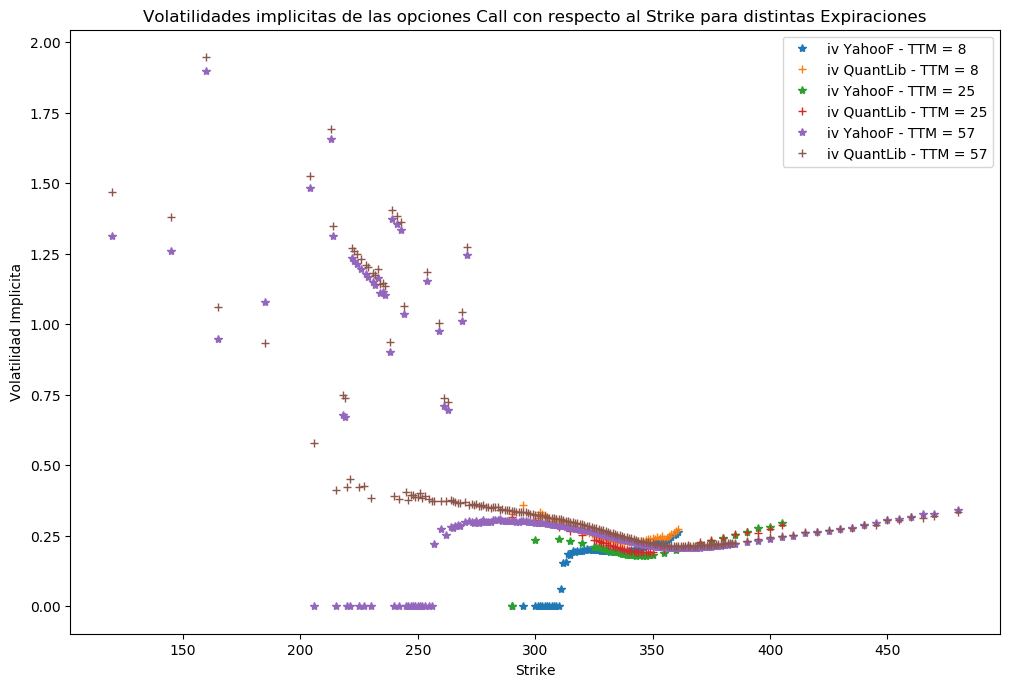

In [17]:

TTMs = list(set(panel_limpio.TTM.values))
TTMs.sort()
TTMs

CP = "C"
for TTM in [TTMs[3], TTMs[10], TTMs[15]]: #TTMs:
    Ks = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].strike.values
    iv_yahoo = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].impliedVolatility.values
    iv_QL = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].ImpliedVolatility_QuantLib.values
    plt.plot(Ks, iv_yahoo, '*',label='iv YahooF - TTM = '+str(TTM))
    plt.plot(Ks, iv_QL, '+',label='iv QuantLib - TTM = '+str(TTM))


plt.legend()

plt.xlabel('Strike')
plt.ylabel('Volatilidad Implicita')
plt.title('Volatilidades implicitas de las opciones Call con respecto al Strike para distintas Expiraciones')
    
plt.show()



Ploteo algunas VI para Puts

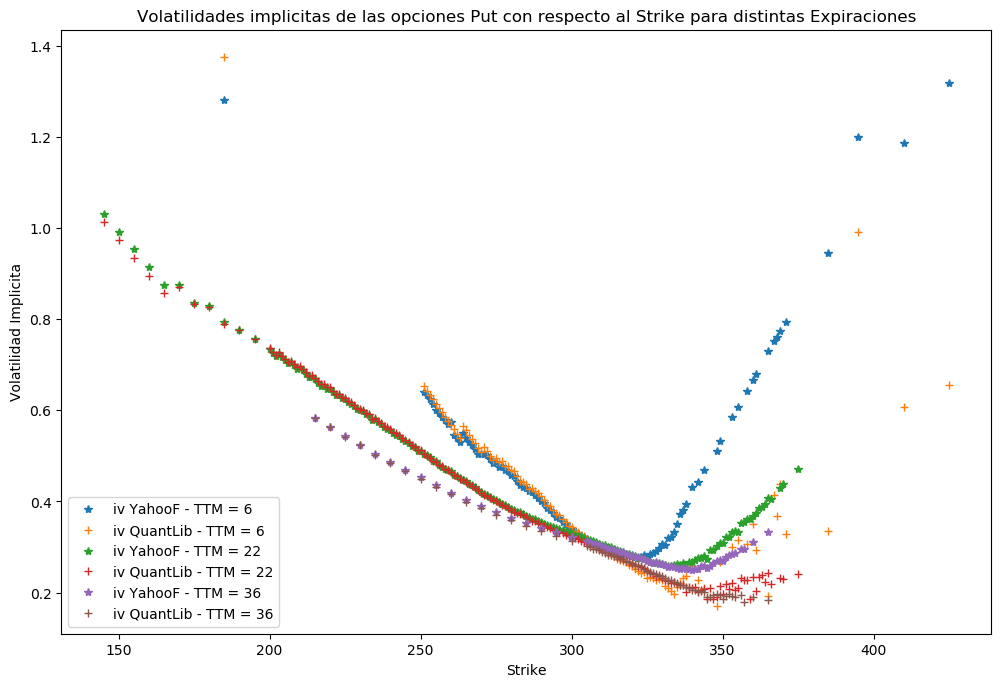

In [18]:

CP = "P"
for TTM in [TTMs[2], TTMs[9], TTMs[14]]: #TTMs:
    Ks = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].strike.values
    iv_yahoo = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].impliedVolatility.values
    iv_QL = panel_limpio[(panel_limpio.TTM == TTM) & (panel_limpio.CallPut == CP)].ImpliedVolatility_QuantLib.values
    plt.plot(Ks, iv_yahoo, '*',label='iv YahooF - TTM = '+str(TTM))
    plt.plot(Ks, iv_QL, '+',label='iv QuantLib - TTM = '+str(TTM))


plt.legend()

plt.xlabel('Strike')
plt.ylabel('Volatilidad Implicita')
plt.title('Volatilidades implicitas de las opciones Put con respecto al Strike para distintas Expiraciones')
    
plt.show()



#plt.plot(panel_limpio.strike, panel_limpio.impliedVolatility, label = 'IV Yahoo Finance')
#plt.plot(panel_limpio.strike, panel_limpio.ImpliedVolatility_QuantLib, label = 'IV QuantLib')

#plt.legend()

#plt.xlabel('Strike')
#plt.ylabel('Volatilidad Implicta')
#plt.title('Volatilidad Implicita')
    
plt.show()
